<a href="https://colab.research.google.com/github/nahlatafi/draft_skinnea/blob/main/%233_Trial_Skripsi_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path ke folder-folder
train_dir = '/content/drive/MyDrive/new-dataset/train'
val_dir = '/content/drive/MyDrive/new-dataset/val'
test_dir = '/content/drive/MyDrive/new-dataset/test'

# Label-label
labels = ['Atopic-Dermatitis', 'Psoriasis', 'Scabies-Lyme']
print('Jumlah kelas:', len(labels))
for i, label in enumerate(labels):
    print(f"{i}: {label}")

# Fungsi untuk menghitung jumlah gambar dalam folder untuk label tertentu
def count_images_in_folder(folder_path, labels):
    label_counts = {label: 0 for label in labels}

    # Menghitung jumlah file gambar untuk setiap label
    for label in labels:
        label_path = os.path.join(folder_path, label)
        files = os.listdir(label_path)
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                label_counts[label] += 1

    return label_counts

# Fungsi untuk menghitung total jumlah gambar dalam sebuah direktori
def count_total_images_in_folder(folder_path, labels):
    total_count = 0
    for label in labels:
        label_path = os.path.join(folder_path, label)
        files = os.listdir(label_path)
        total_count += len([file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))])
    return total_count

# Menghitung jumlah file gambar untuk setiap label di direktori pelatihan
train_label_counts = count_images_in_folder(train_dir, labels)
total_train_images = sum(train_label_counts.values())

print("\nJumlah Data Training:", total_train_images)
for label, count in train_label_counts.items():
    print(f"{label}: {count}")

# Menghitung jumlah file gambar untuk setiap label di direktori validasi
val_label_counts = count_images_in_folder(val_dir, labels)
total_val_images = sum(val_label_counts.values())

print("\nJumlah Data Validation:", total_val_images)
for label, count in val_label_counts.items():
    print(f"{label}: {count}")

# Menghitung jumlah file gambar untuk setiap label di direktori pengujian
test_label_counts = count_images_in_folder(test_dir, labels)
total_test_images = sum(test_label_counts.values())

print("\nJumlah Data Testing:", total_test_images)
for label, count in test_label_counts.items():
    print(f"{label}: {count}")


Jumlah kelas: 3
0: Atopic-Dermatitis
1: Psoriasis
2: Scabies-Lyme

Jumlah Data Training: 90
Atopic-Dermatitis: 30
Psoriasis: 30
Scabies-Lyme: 30

Jumlah Data Validation: 90
Atopic-Dermatitis: 30
Psoriasis: 30
Scabies-Lyme: 30

Jumlah Data Testing: 90
Atopic-Dermatitis: 30
Psoriasis: 30
Scabies-Lyme: 30


In [ ]:
# Menentukan parameter untuk model
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

In [ ]:
# Augmentasi data dengan parameter yang lebih beragam
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="validation",
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 54 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [ ]:
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import GlobalAveragePooling2D

# Memuat pre-trained model sebagai feature extractor
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,), output_shape=[FV_SIZE])

# Membangun model dengan layers tambahan
model = Sequential([
    feature_extractor,
    Flatten(),
    # GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # BatchNormalization(),
    Dropout(rate=0.5),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # BatchNormalization(),
    Dropout(rate=0.5),
    Dense(len(labels), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Kompilasi model
LEARNING_RATE = 0.001
model.compile(
   optimizer=Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

In [ ]:
# Melatih model
EPOCHS = 15  # Sesuaikan dengan jumlah epoch yang diinginkan
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping])

Epoch 1/15
3/3 [==============================] - 7s 3s/step - loss: 1.5103 - accuracy: 0.8750 - val_loss: 2.4206 - val_accuracy: 0.6250
Epoch 2/15
3/3 [==============================] - 5s 2s/step - loss: 1.5058 - accuracy: 0.8684 - val_loss: 2.4907 - val_accuracy: 0.5938
Epoch 3/15
3/3 [==============================] - 4s 2s/step - loss: 1.6523 - accuracy: 0.7105 - val_loss: 2.4546 - val_accuracy: 0.5625
Epoch 4/15
3/3 [==============================] - 4s 2s/step - loss: 1.4315 - accuracy: 0.7895 - val_loss: 2.0822 - val_accuracy: 0.6875
Epoch 5/15
3/3 [==============================] - 4s 1s/step - loss: 1.2844 - accuracy: 0.9737 - val_loss: 2.4200 - val_accuracy: 0.5938
Epoch 6/15
3/3 [==============================] - 3s 1s/step - loss: 1.5053 - accuracy: 0.8421 - val_loss: 2.4882 - val_accuracy: 0.6562
Epoch 7/15
3/3 [==============================] - 3s 1s/step - loss: 1.2543 - accuracy: 0.8750 - val_loss: 2.4288 - val_accuracy: 0.6562
Epoch 8/15
3/3 [=========================

In [ ]:
# # Membuka beberapa lapisan terakhir dari base model untuk fine-tuning
# feature_extractor.trainable = True

# # Memilih berapa banyak lapisan yang ingin dibuka (misal, 20 lapisan terakhir)
# fine_tune_at = len(feature_extractor.layers) - 20

# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# # Mengkompilasi ulang model setelah membuka beberapa lapisan
# model.compile(optimizer=Adam(learning_rate=0.00001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Melanjutkan pelatihan model dengan fine-tuning
# history_fine = model.fit(train_generator,
#                          steps_per_epoch=train_generator.samples // BATCH_SIZE,
#                          epochs=15,
#                          validation_data=validation_generator,
#                          validation_steps=validation_generator.samples // BATCH_SIZE,
#                          callbacks=[early_stopping])

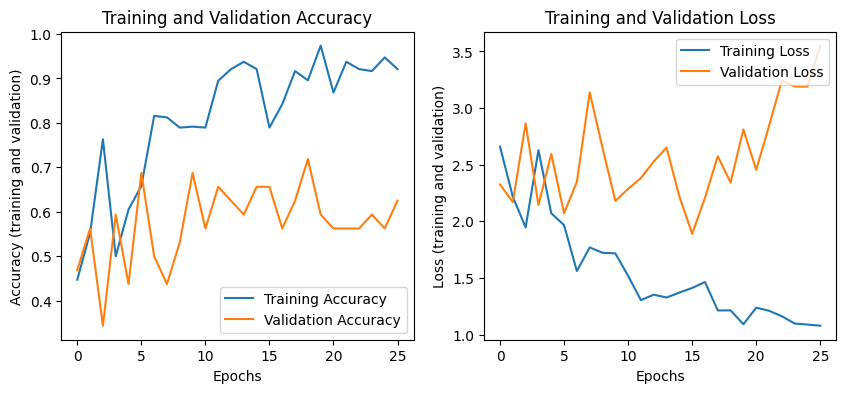

In [ ]:
# Mendefinisikan epochs_range berdasarkan panjang akurasi
epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Epochs")
plt.show()


In [ ]:
# # epochs_range = range(len(history.history['accuracy']))

# import matplotlib.pylab as plt
# import numpy as np

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)

# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
# plt.ylabel("Accuracy (training and validation)")
# plt.xlabel("Training Steps")

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.ylabel("Loss (training and validation)")
# plt.xlabel("Training Steps")
# plt.show()

In [ ]:
# Evaluasi model pada data validasi
evaluates = model.evaluate(validation_generator)
print(f"Validation Accuracy: {evaluates[1]:.2f}")

3/3 [==============================] - 2s 268ms/step - loss: 2.1571 - accuracy: 0.7222
Validation Accuracy: 0.72


In [ ]:
# Prediksi menggunakan data validasi untuk perhitungan classification report dan confusion matrix
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

# print(evaluates)

3/3 [==============================] - 2s 406ms/step
Classification Report
                   precision    recall  f1-score   support

Atopic-Dermatitis       0.67      0.50      0.57        12
        Psoriasis       0.69      0.75      0.72        12
     Scabies-Lyme       0.64      0.75      0.69        12

         accuracy                           0.67        36
        macro avg       0.67      0.67      0.66        36
     weighted avg       0.67      0.67      0.66        36

3/3 [==============================] - 2s 257ms/step - loss: 2.1742 - accuracy: 0.6944


1/1 [==============================] - 1s 1s/step
Prediksi untuk gambar Psoriasis/Psoriasis (14).jpg:
Kelas: Psoriasis, Confidence: 0.3934781551361084


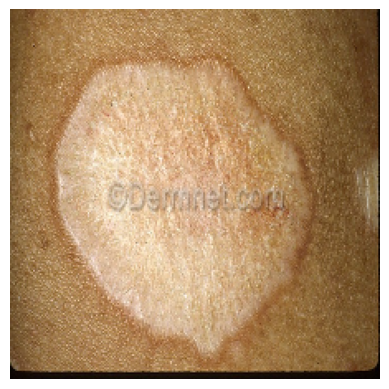

1/1 [==============================] - 0s 87ms/step
Prediksi untuk gambar Psoriasis/Psoriasis (1).jpg:
Kelas: Psoriasis, Confidence: 0.8876132965087891


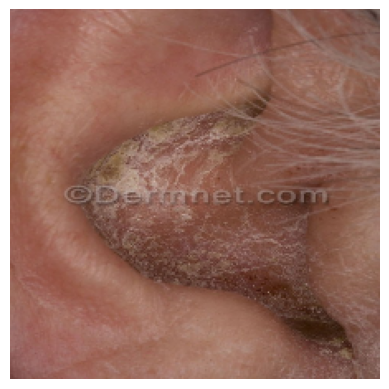

1/1 [==============================] - 0s 51ms/step
Prediksi untuk gambar Scabies-Lyme/Scabies-Lyme (15).jpg:
Kelas: Scabies-Lyme, Confidence: 0.6108691096305847


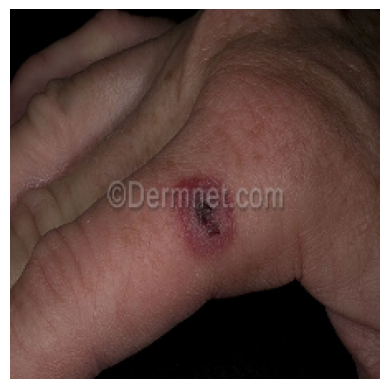

1/1 [==============================] - 0s 45ms/step
Prediksi untuk gambar Scabies-Lyme/Scabies-Lyme (10).jpg:
Kelas: Scabies-Lyme, Confidence: 0.5944234728813171


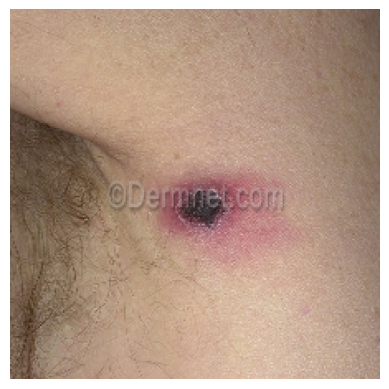

1/1 [==============================] - 0s 53ms/step
Prediksi untuk gambar Scabies-Lyme/Scabies-Lyme (13).jpg:
Kelas: Scabies-Lyme, Confidence: 0.9338241815567017


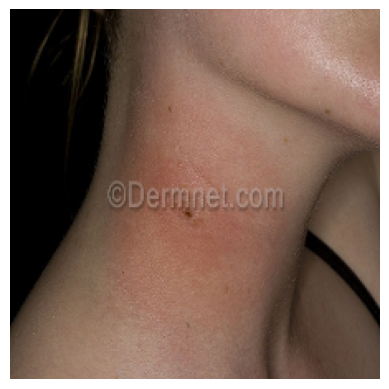

1/1 [==============================] - 0s 48ms/step
Prediksi untuk gambar Atopic-Dermatitis/Atoppic-Dermatitis (18).jpg:
Kelas: Scabies-Lyme, Confidence: 0.9926190972328186


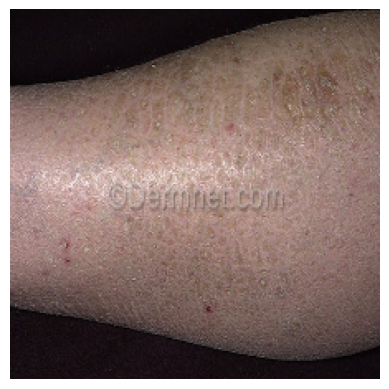

1/1 [==============================] - 0s 61ms/step
Prediksi untuk gambar Psoriasis/Psoriasis (16).jpg:
Kelas: Scabies-Lyme, Confidence: 0.9677501320838928


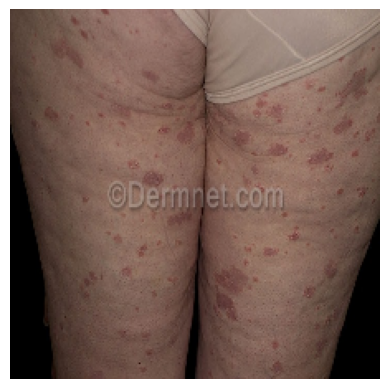

1/1 [==============================] - 0s 49ms/step
Prediksi untuk gambar Scabies-Lyme/Scabies-Lyme (14).jpg:
Kelas: Scabies-Lyme, Confidence: 0.8578531742095947


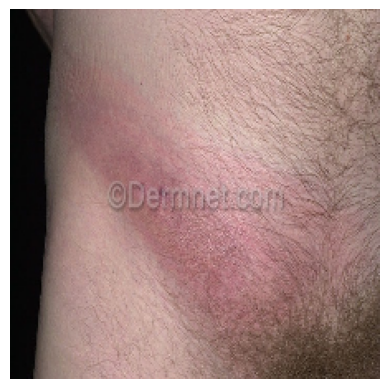

1/1 [==============================] - 0s 61ms/step
Prediksi untuk gambar Scabies-Lyme/Scabies-Lyme (2).jpg:
Kelas: Scabies-Lyme, Confidence: 0.9431095719337463


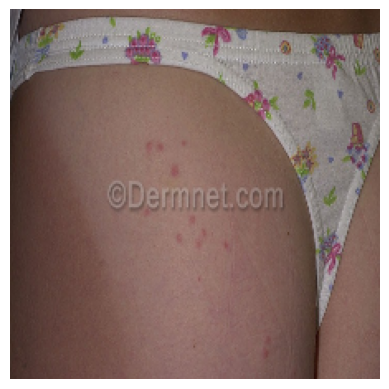

1/1 [==============================] - 0s 50ms/step
Prediksi untuk gambar Psoriasis/Psoriasis (11).jpg:
Kelas: Psoriasis, Confidence: 0.980735719203949


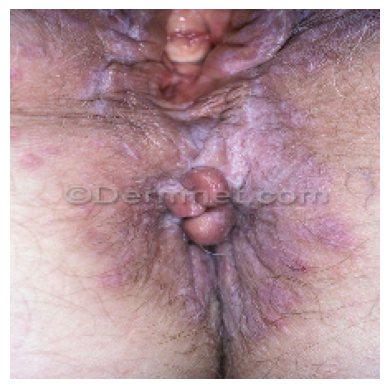

1/1 [==============================] - 0s 75ms/step
Prediksi untuk gambar Atopic-Dermatitis/Atoppic-Dermatitis (1).jpg:
Kelas: Scabies-Lyme, Confidence: 0.6965668201446533


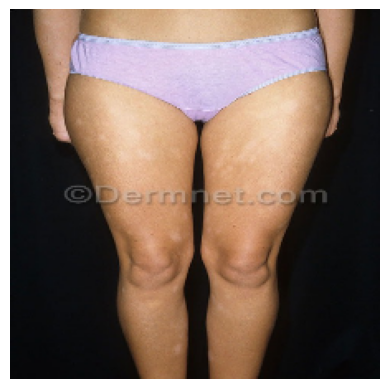

1/1 [==============================] - 0s 48ms/step
Prediksi untuk gambar Atopic-Dermatitis/Atoppic-Dermatitis (2).jpg:
Kelas: Atopic-Dermatitis, Confidence: 0.9989472031593323


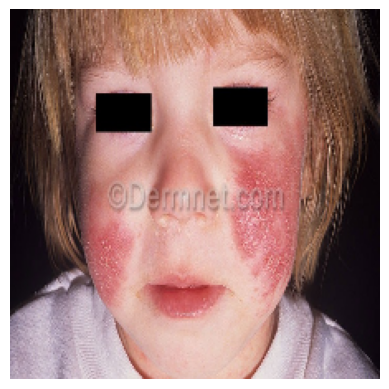

1/1 [==============================] - 0s 48ms/step
Prediksi untuk gambar Scabies-Lyme/Scabies-Lyme (11).jpg:
Kelas: Scabies-Lyme, Confidence: 0.7060986161231995


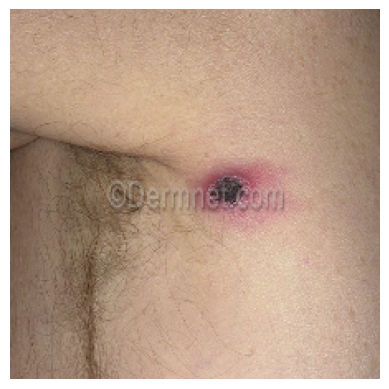

1/1 [==============================] - 0s 56ms/step
Prediksi untuk gambar Psoriasis/Psoriasis (17).jpg:
Kelas: Psoriasis, Confidence: 0.6425317525863647


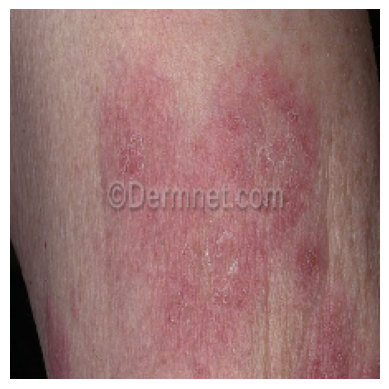

1/1 [==============================] - 0s 71ms/step
Prediksi untuk gambar Psoriasis/Psoriasis (2).jpg:
Kelas: Psoriasis, Confidence: 0.43559399247169495


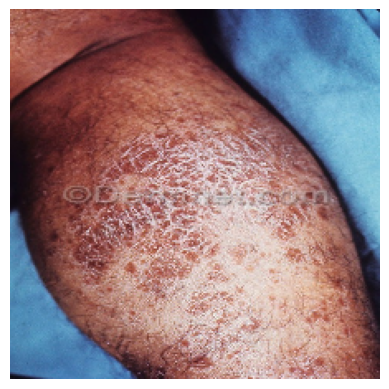

1/1 [==============================] - 0s 78ms/step
Prediksi untuk gambar Atopic-Dermatitis/Atoppic-Dermatitis (10).jpg:
Kelas: Scabies-Lyme, Confidence: 0.8588506579399109


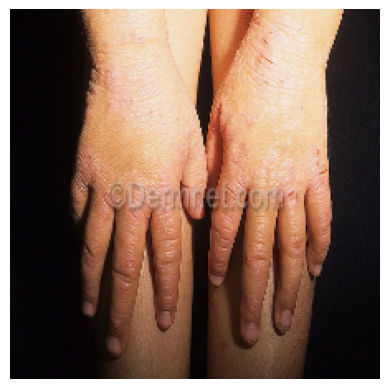

In [ ]:
# Contoh prediksi untuk 16 gambar acak dari data validasi
sample_images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(sample_images):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (pixels, pixels))
    # Konversi gambar ke float setelah mengubah ukuran
    img_float = img / 255.0

    prediction = model.predict(np.expand_dims(img_float, axis=0))[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]

    print(f"Prediksi untuk gambar {filename}:")
    print(f"Kelas: {labels[predicted_class]}, Confidence: {confidence}")

    # Gunakan gambar asli (img) untuk ditampilkan, karena cv2.cvtColor mengharapkan gambar 8-bit
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

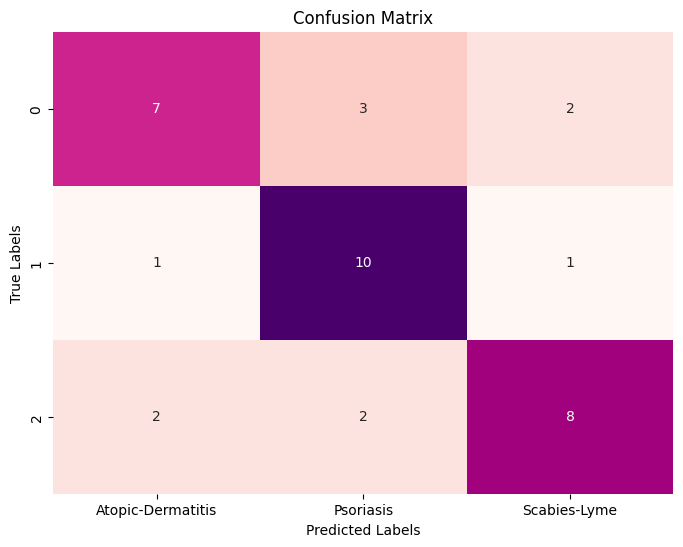

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_df = pd.DataFrame(conf_matrix, columns=validation_generator.class_indices)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, cmap='RdPu', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()